In [1]:
import os

if not os.path.exists("groundtruth-drosophila-vnc"):
    os.system("git clone https://github.com/unidesigner/groundtruth-drosophila-vnc")

raw_path = os.path.join("groundtruth-drosophila-vnc", "stack1", "raw")
label_path = os.path.join("groundtruth-drosophila-vnc", "stack1", "labels")

train_images_paths = os.listdir(raw_path)

print(f"{len(train_images_paths)} training images")

20 training images


In [2]:
import deeptrack as dt
import torch

dt.config.disable_image_wrapper()

raw_paths = dt.sources.ImageFolder(root=raw_path)
label_paths = dt.sources.ImageFolder(root=label_path)

raw_sources = raw_paths.product(flip_ud=[True, False], flip_lr=[True, False])
label_sources = label_paths.product(flip_ud=[True, False], flip_lr=[True, False])

2024-01-24 18:41:54.432501: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import numpy as np


def select_labels(class_labels=None):
    def inner(gt_seg_image):
        gt_seg_image = gt_seg_image.copy()
        masked_gt_seg_imag = gt_seg_image * np.isin(gt_seg_image, class_labels).astype(
            np.uint8
        )
        replace = np.arange(len(class_labels)) + 1
        gt_seg_image_new_labels = np.select(
            [masked_gt_seg_imag == cl for cl in class_labels], replace
        ).astype(np.uint8)
        out = np.eye(len(class_labels) + 1)[gt_seg_image_new_labels.squeeze()]

        return out

    return inner

In [4]:
im_pipeline = dt.LoadImage(raw_sources.path) >> dt.NormalizeMinMax()
lab_pipeline = dt.LoadImage(label_sources.path) >> dt.Lambda(
    select_labels, class_labels=[255, 191]
)

pipeline = (
    (im_pipeline & lab_pipeline)
    >> dt.Crop(crop=(256, 256, None))
    >> dt.FlipLR(raw_sources.flip_lr)
    >> dt.FlipUD(raw_sources.flip_ud)
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

In [12]:
# my first version
im_pipeline = (
    dt.LoadImage(raw_sources.path)
    # >> dt.Crop(crop=(256, 256, None))
    >> dt.NormalizeMinMax()
    >> dt.FlipLR(raw_sources.flip_lr)
    >> dt.FlipUD(raw_sources.flip_ud)
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)


lab_pipeline = (
    dt.LoadImage(label_sources.path)
    # >> dt.Crop(crop=(256, 256, None))
    >> dt.Lambda(select_labels, class_labels=[255, 191])
    >> dt.FlipLR(label_sources.flip_lr)
    >> dt.FlipUD(label_sources.flip_ud)
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

# pipeline = (im_pipeline) & (lab_pipeline)
pipeline = (im_pipeline & lab_pipeline) >> dt.Crop(crop=(None, 256, 256))

In [37]:
np.random.rand(1, 1)

array([[0.92604252]])

In [44]:
idxs = np.random.choice(np.linspace(0, 19, 20).astype(int), 3, replace=False)
print(idxs)

[19 15  3]


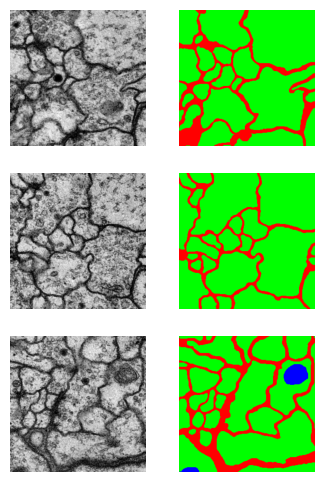

In [13]:
import matplotlib.pyplot as plt

idxs = np.random.choice(np.linspace(0, 19, 20).astype(int), 3, replace=False)

fig, axs = plt.subplots(3, 2, figsize=((4, 6)))
for i, k in enumerate(idxs):
    image, label = pipeline([raw_sources[k], label_sources[k]])
    axs[i, 0].imshow(image.permute(1, 2, 0), cmap="gray")
    axs[i, 0].set_axis_off()
    axs[i, 1].imshow(label.permute(1, 2, 0), cmap="gray")
    axs[i, 1].set_axis_off()